# Better MNIST Predictions with PyTorch

**It is recommended that you complete this notebook in Google Colab:**
- otherwise you may encounter errors
- this will allow you to access free GPU resources

---
In this notebook, we'll take a look at an important limitation of logistic regression and MLP models applied to images, then overcome these limitations by training a shallow CNN in PyTorch.

Goals are as follows:

- Observe that logistic regression is *not* effective when digits are not centered (why?)
- Train a simple CNN to identify digits *even when their position varies*
- Visualize the filters for each digit learned by the CNN
- Create and train a model that classifies handwritten digits with over 98% accuracy

We'll begin by importing required libraries:

- numpy for efficient math operations
- sklearn for defining and training our logistic regression and MLP models
- matplotlib for visualization/plotting
- torch modules for neural networks, optimization functions, activation functions, and creating baches

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch


As before, we'll load the MNIST dataset. The data are already broken down into:

1. a development set, which we'll use for training
2. a test set, which we'll use to evaluate performance

As in the previous exercise, we will not be tuning our models, so we will not set aside a validation set.

In [2]:
from torchvision import datasets, transforms

# Load MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True)

# Extract data and labels (seperate images and labels)
x_dev = train_dataset.data  # Shape: (60000, 28, 28)
y_dev = train_dataset.targets  # Shape: (60000,)

x_test = test_dataset.data  # Shape: (10000, 28, 28)
y_test = test_dataset.targets  # Shape: (60000,)



# Normalize values so that they range from 0 to 1
x_dev = x_dev / 255.
x_test = x_test / 255.

print('There are', len(x_dev), 'training images.')
print('There are', len(x_test), 'test images.')

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.26MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

There are 60000 training images.
There are 10000 test images.


To review code that allows us to inspect the images and labels, please review [Computational Exercise 5](https://github.com/mengelhard/bsrt_ml4h/blob/master/notebooks/ce5.ipynb).

## Un-Centering our Digits
In MNIST, all digits are centered, which substantially simplifies the problem. In many real-world datasets, on the other hand, we need to identify image features regardless of where they may be present within the image. Let's explore this issue by modifying MNIST so that digits are no longer centered. We'll first enlarge the images, then place digits at random positions within the enlarged image. We'll do this by padding each image (in both our development and test sets) with zeroes.

In [3]:
def pad_image(img, pad_len):
    m, n = img.shape
    i = np.random.randint(pad_len - 2) + 1 # pick a horizontal offset between 1 and (pad_len - 1)
    j = np.random.randint(pad_len - 2) + 1 # pick a vertical offset bewteen 1 and (pad_len - 1)
    img = np.concatenate([[[0] * i] * m, img, [[0] * (pad_len - i)] * m], axis=1) # pad horizontally
    img = np.concatenate([[[0] * (n + pad_len)] * j, img, [[0] * (n + pad_len)] * (pad_len - j)], axis=0) # pad vertically
    return img

x_dev_padded = np.array([pad_image(x, 20) for x in x_dev])
x_test_padded = np.array([pad_image(x, 20) for x in x_test])

In the plots below, we see that digits are no longer centered in the modified dataset.

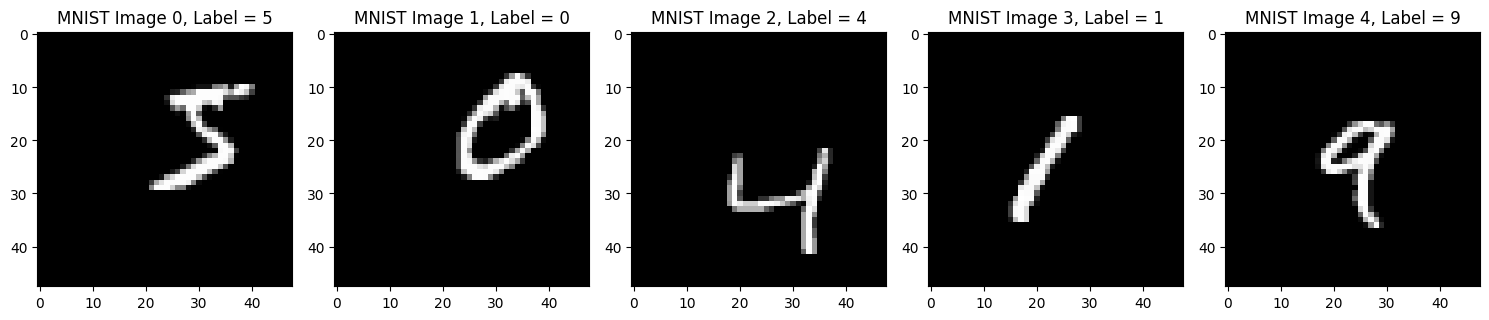

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))
for i in range(5):
    ax[i].imshow(x_dev_padded[i, :, :], cmap='gray')
    ax[i].set_title('MNIST Image %i, Label = %i' % (i, y_dev[i]), fontsize=12)
plt.tight_layout()
plt.show()

## Exercise 1: Logistic Regression
Let's see whether logistic regression is able to classify digits effectively now that they're not centered. In the following block, you should:
- Train a logistic regression model (i.e. LogisticRegression()) to predict the labels of digits in MNIST.
- After training a model on the development set, evaluate its accuracy on the test set. As in the previous computational excercise, you'll need to flatten the images in order to use logistic regression. Remember that your predictions are no longer binary; instead, you are predicting one of ten different digits.
- Visualize the logistic regression filters using the same or similar code as in [computational exercise 5](https://github.com/mengelhard/bsrt_ml4h/blob/master/notebooks/ce5.ipynb). Note that since we've padded the images, the filters are now (48, 48) in size rather than (28, 28).

In [ ]:
from sklearn.linear_model import LogisticRegression

### CREATE A LOGISTIC REGRESSION MODEL AND TRAIN IT ON THE FLATTENED DEVELOPMENT SET ###


### USE THE TRAINED MODEL TO MAKE PREDICTIONS ON THE (FLATTENED) TEST SET ###


### EVALUATE THE ACCURACY OF THE MODEL'S PREDICTIONS ON THE TEST SET ###

In [ ]:
### ACCESS THE MODEL COEFFICIENTS ###


### RESHAPE EACH OF THE 10 COEFFICIENT VECTORS TO HAVE SHAPE (48, 48) ###


### PLOT EACH OF THE RESHAPED VECTORS (i.e. FILTERS) ###

## Our First Pytorch Model
---
Lets create a simple CNN, thats has the following properties.
1. **10 Filters**: one for each digit each of size 28 x 28 (same size as each unmodified MNIST image).
2. The CNN we are creating is unusual and inefficient due to the small number of filters, where each are relatively large in size.
3. We will max pool the output of each filter across each image. We want to pool the filters, so we can see if the digit corresponding to that filter is present in the whole image.
   - The output of the **Pooling Operation** will give us the predicted **log-odds** for each of the 10 digits.
4. **Steps**
   1. Convert our `MNIST` image dataset into Tensors, so the images can be passed into the `PyTorch` Model.
   2. Split training, and test datasets into batches. We will use a batch size of 32, which means that the model will process 32 images at a time.

In [6]:
from torch.utils.data import DataLoader, TensorDataset

# convert training and test datasets to tensor
train_ds = TensorDataset(
    torch.tensor(x_dev_padded, dtype=torch.float32), # features
    y_dev.to(dtype=torch.long)
)
test_ds = TensorDataset(
    torch.tensor(x_test_padded, dtype=torch.float32),
    y_test.to(dtype=torch.long)
)

# create batch size of 32
train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

#### Code Explanation

We first convert the training (`x_dev_padded` and `y_dev`) and test (`x_test_padded` and `y_test`) into **Tensors** using `TensorDataset` from the `torch.utils.data` module.

We then use the tensor objects (`train_ds` and `test_ds`) to create data loaders with a batch size of  32 (`train_loader` and `test_loader`). This is done using PyTorch's `DataLoader` class, which handles batches and other features like shuffling.

We can then loop over our batches as shown in the next block. Here our goal is just to see what a single batch looks like, so we'll break the loop after printing out the first batch.

In [7]:
for images, labels in train_loader:
    print('The images have shape', images.numpy().shape)
    print('The labels have shape', labels.numpy().shape)
    break

The images have shape (32, 48, 48)
The labels have shape (32,)


## Defining the Model

To create the model, we need to make different types of layers (dense layers, convolutional layers, max pool layers, flatten layers).

1. `Conv2d`: Convolutional layers, with:
   - `in_channels`=1, refers to grayscale images
   - `out_channels`=10, refers to the 10 features (numbers 0 to 9)
   - `kernel_size`=28, refers to filter size 28x28
   - `bias`=false, means no bias term is used in the `Conv2d` layer
2. `nn.MaxPool2d`: This is the max pooling layer
   - `kernel_size`=21, size of pooling window is 21x21
3. `nn.Flatten()`: flattening layer; after applying convolution and pooling we must turn the multi-dimension tensor into a 1D vector

To make this model we are using `Module` from `torch.nn`. The forward method defines operation to apply to the input tensor `x`.
- `x.unsqueeze(1)`: Adds a channel dimension to `x`
- `self.conv1`: Aplies the convolutional layer to `x`
- `self.mp1`: passes feature maps through max pooling layer, to find maximum value within 21x21
- `self.flatten` flattens the multidimensional tensor into a 1D vector

In [8]:
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10): #in_channel refers to color, but for MNIST its always 1
        super(SimpleCNN, self).__init__()
        self.conv1=nn.Conv2d(in_channels=1, out_channels=10, kernel_size=28, bias=False)
        self.mp1=nn.MaxPool2d(kernel_size=21)
        self.flatten=nn.Flatten()

    def forward(self, x):
        x=x.unsqueeze(1)
        x=self.conv1(x)
        x=self.mp1(x)
        x=self.flatten(x)

        return(x)

We can then create an instance of our `SimpleCNN`, just as we did when using `LogisticRegression` or `MLPClassifier` in `sklearn`.

In [9]:
model = SimpleCNN()

Before training our model, we must first create **loss** and **optimization** objects
- We will create the `loss_object` to calculate the cross-entropy loss based on two factors
  1. Model's predicted logits
  2. True labels in training set
- We will create the `optimizer` object to determine model's parameters based on Adam optimizer (modified form of stochastic gradient descent).

In [10]:
loss_object = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

We will now train our model `model`, by looping over all batches in training set by the number of epochs. Epochs are a full pass through the entire training dataset. We'll loop over all the batches in our training set 5 times in a row (i.e. 5 EPOCHS). For each batch, we'll:
1. apply our model to generate predictions for that batch
2. calculate the loss based on those predictions
3. calculate the gradient of the loss (i.e. how much does loss change in respose to changes in each parameter)
4. use our optimizer to adjust the model parameters (i.e. `model.trainable_variables`) based on the gradient.
5. Finally we will calculate the accuracy for each epoch
**Important**: This code will be very slow unless you switch to a GPU runtime from the Colab menu. Even with this change, it'll still take a minute or two.
- Runtime > Change runtime type

In [11]:
num_epochs=5

for epoch in range(num_epochs):
    train_accuracy = []
    test_accuracy = []

    model.train()
# training loop
    for images, labels in train_loader:
        predicted_logits = model(images)
        loss = loss_object(predicted_logits, labels)

# backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Calculate accuracy
        _, predicted_labels = torch.max(predicted_logits, 1)  # Get predicted class indices
        batch_accuracy = (predicted_labels == labels).float().mean().item()  # Mean accuracy for batch
        train_accuracy.append(batch_accuracy)

# evaluation loop
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations during evaluation
        for images, labels in test_loader:
            # Forward pass
            predicted_logits = model(images)

            # Calculate test accuracy
            _, predicted_labels = torch.max(predicted_logits, 1)
            batch_accuracy = (predicted_labels == labels).float().mean().item()
            test_accuracy.append(batch_accuracy)

    # calculate accuracy
    train_accuracy = 100 * np.mean(train_accuracy)
    test_accuracy = 100 * np.mean(test_accuracy)
    print(f'Epoch {epoch + 1}: train accuracy = {train_accuracy:.1f}%, test accuracy = {test_accuracy:.1f}%')

Epoch 1: train accuracy = 85.9%, test accuracy = 91.7%
Epoch 2: train accuracy = 92.3%, test accuracy = 93.2%
Epoch 3: train accuracy = 93.5%, test accuracy = 94.0%
Epoch 4: train accuracy = 94.2%, test accuracy = 94.3%
Epoch 5: train accuracy = 94.6%, test accuracy = 94.5%


## Exercise 2: Visualize the filters learned by the CNN
The filters of the trained model can be accessed as an attribute of the `model.conv1.weight` layer, as shown in the first line of the block below. `filters` will be an array of size (10, 28, 28) corresponding to the 10 filters -- one for each digit -- each of which is the same size (28 by 28) as the images. In the following block, you should plot and inspect these filters.

In [ ]:
filters = model.conv1.weight.data.numpy()
filters = (filters - filters.min()) / (filters.max() - filters.min()) # normalize values

filters = filters.squeeze(1)
### PLOT EACH OF THE 10 28 by 28 FILTERS ###



## Exercise 3: Better CNN
**Note: This exercise is optional for those not already familar with Python**

The CNN we created above is inefficient due to the large size of each filter (28x28).

In this exercise, you'll build a better CNN, train it, and evaluate it.
- Create the model by following the prompts in the code block below.
- Then, duplicate code blocks above to create an instance of `BetterCNN`, train it, and evaluate its performance on the test set.

The following may also be interesting, though none is required:
- visualize the learned filters in the convolutional layer.
- modify the architecture to see if performance can be further improved.

The following blocks, repeated from above, can now be used to train and evaluate `BetterCNN`.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BetterCNN(Model):
    def __init__(self):
        super(BetterCNN, self).__init__()
        ### DEFINE A CONVOLUTIONAL LAYER WITH 32 FILTERS OF SIZE 3 (i.e. 3x3) AND input size of 1 ###
        ### DEFINE A MAX POOL LAYER WITH 2x2 POOL SIZE ###
        ### DEFINE A SECOND CONVOLUTIONAL LAYER WITH 32 FILTERS OF SIZE 5 AND RELU ACTIVATION ###
        ### DEFINE A FLATTEN LAYER ###
        ### DEFINE A DENSE LAYER WITH OUTPUT SIZE 128  ###
        ### DEFINE A DENSE LAYER WITH OUTPUT SIZE 10. THIS IS THE FINAL LAYER; OUTPUT WILL BE THE LOG-ODDS ###

    def forward(self, x):
        x = x.unsqueeze(1)
        #x = ### APPLY FIRST CONVOLUTIONAL LAYER ###
        #x = ### APPLY MAX POOL LAYER ###
        #x = ### APPLY SECOND CONVOLUTIONAL LAYER ###
        #x = ### APPLY MAX POOL LAYER ###
        #x = ### APPLY FLATTEN LAYER ###
        #x = ### APPLY FIRST DENSE LAYER ###
        #x = ### APPLY SECOND DENSE LAYER ###
        return x


### SIDE NOTE: I recommend you apply the F.relu() method to the Conv2D, and  Dense Layers for better results.

In [ ]:
model = BetterCNN()
loss_object = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs=5

for epoch in range(num_epochs):
    train_accuracy = []
    test_accuracy = []

    model.train()
# training loop
    for images, labels in train_loader:
        predicted_logits = model(images)
        loss = loss_object(predicted_logits, labels)

# backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Calculate accuracy
        _, predicted_labels = torch.max(predicted_logits, 1)  # Get predicted class indices
        batch_accuracy = (predicted_labels == labels).float().mean().item()  # Mean accuracy for batch
        train_accuracy.append(batch_accuracy)

# evaluation loop
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations during evaluation
        for images, labels in test_loader:
            # Forward pass
            predicted_logits = model(images)

            # Calculate test accuracy
            _, predicted_labels = torch.max(predicted_logits, 1)
            batch_accuracy = (predicted_labels == labels).float().mean().item()
            test_accuracy.append(batch_accuracy)

    # calculate accuracy
    train_accuracy = 100 * np.mean(train_accuracy)
    test_accuracy = 100 * np.mean(test_accuracy)
    print(f'Epoch {epoch + 1}: train accuracy = {train_accuracy:.1f}%, test accuracy = {test_accuracy:.1f}%')

Epoch 1: train accuracy = 86.0%, test accuracy = 95.2%
Epoch 2: train accuracy = 95.6%, test accuracy = 95.6%
Epoch 3: train accuracy = 97.3%, test accuracy = 95.6%
Epoch 4: train accuracy = 98.1%, test accuracy = 95.0%
Epoch 5: train accuracy = 98.6%, test accuracy = 96.9%


## Steps to distribute your work as an html file:

If you're using Anaconda on your local machine:
- download your notebook as html (see `File > Download as > HTML (.html)`)

If you're using Google Colab:
- download your notebook as .ipynb (see `File > Download > Download .ipynb`)
- if you have nbconvert installed, convert it to .html and submit it in Talent LMS
- if not, you may need to place the .ipynb file in a .zip archive in order to distribute it (e.g. to upload or send via email)